In [1]:
%load_ext autoreload
%autoreload 2
import spikeinterface.full as si
from probeinterface.plotting import plot_probe, plot_probegroup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from scipy import stats
import os
from Helpers import plot_utility
from astropy.nddata import block_reduce
import matplotlib.ticker as ticker
from Helpers.plot_utility import pandas_collumn_to_2d_numpy_array, pandas_collumn_to_numpy_array
from P3_CurrentAnalysis.basic_lomb_scargle_estimator import lomb_scargle_parallel
from P2_PostProcess.VirtualReality.plotting import *


In [34]:
def plot_stop_hists(processed_position_data, track_length, ax=None, ymax=1):
    bin_size = 5
    for tt in np.unique(processed_position_data["trial_type"]):
        tt_trials = processed_position_data[processed_position_data["trial_type"] == tt]

        stops = []
        tt_trial_numbers = []
        for i, tn in enumerate(tt_trials["trial_number"]):
            stops.extend(tt_trials["stop_location_cm"].iloc[i])
            tt_trial_numbers.extend(np.ones(len(tt_trials["stop_location_cm"].iloc[i])) * tn)
        stops, tt_trial_numbers = curate_stops(stops, tt_trial_numbers, track_length)

        hist, bin_edges = np.histogram(stops, bins=int(track_length / bin_size), range=(0, track_length))
        hist = hist/len(tt_trials)

        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        ax.plot(bin_centres, hist, '-', color=get_trial_color(tt), linewidth=2)

    ax.set_xlim(0, track_length)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim(0, np.round(ymax+0.01, decimals=2))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plot_utility.style_track_plot(ax, track_length)
    plot_utility.style_vr_plot(ax)
    ax.set_yticks([0, ymax])
    ax.set_yticklabels(["", str(ymax)])
    ax.set_xticks([0,100,200])



def plot_vr_stop_rasters(processed_position_data, save_path, title, track_length):
    fig, axs = plt.subplots(5, 6, figsize=(15, 10), sharex=True, sharey=False)
    fig.suptitle(title, fontsize=16)

    days = np.unique(processed_position_data["session_number"])
    for idx, day in enumerate(days):
        ax = axs.flat[idx]
        day_processed_position_data = processed_position_data[processed_position_data["session_number"] == day]
        for index, trial_row in day_processed_position_data.iterrows():
            trial_row = trial_row.to_frame().T.reset_index(drop=True)
            trial_type = trial_row["trial_type"].iloc[0]
            trial_number = trial_row["trial_number"].iloc[0]
            trial_stop_color = get_trial_color(trial_type)

            ax.plot(np.array(trial_row["stop_location_cm"].iloc[0]),
                    trial_number * np.ones(len(trial_row["stop_location_cm"].iloc[0])),
                    '|', color=trial_stop_color, markersize=4, alpha=0.1)

        ax.set_xlim(0, track_length)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylim(0, max(day_processed_position_data["trial_number"]))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        plot_utility.style_track_plot(ax, track_length)
        plot_utility.style_vr_plot(ax, len(day_processed_position_data)+0.5)
        ax.set_yticks([0, max(day_processed_position_data["trial_number"])])
        ax.set_yticklabels(["", str(max(day_processed_position_data["trial_number"]))])
        ax.set_title(f'Day {day}')

    # Set shared x and y labels
    fig.text(0.5, 0.04, 'Location (cm)', ha='center', fontsize=18)
    fig.text(0.04, 0.5, 'Trial number', va='center', rotation='vertical', fontsize=18)
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.subplots_adjust(left=0.1, bottom=0.1)
    plt.savefig(save_path + title + '_stop_rasters.png', dpi=200)
    return



def plot_stop_raster(processed_position_data, track_length, ax=None):
    bin_size = 5
    for tt in np.unique(processed_position_data["trial_type"]):
        tt_trials = processed_position_data[processed_position_data["trial_type"] == tt]

        for index, trial_row in tt_trials.iterrows():
            trial_row = trial_row.to_frame().T.reset_index(drop=True)
            trial_type = trial_row["trial_type"].iloc[0]
            trial_number = trial_row["trial_number"].iloc[0]
            trial_stop_color = get_trial_color(trial_type)

            ax.plot(np.array(trial_row["stop_location_cm"].iloc[0]),
                    trial_number * np.ones(len(trial_row["stop_location_cm"].iloc[0])),
                    '|', color=trial_stop_color, markersize=4, alpha=0.1)

    ax.set_xlim(0, track_length)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plot_utility.style_track_plot(ax, track_length)
    plot_utility.style_vr_plot(ax, len(processed_position_data)+0.5)
    ax.set_yticks([0, len(processed_position_data)])
    ax.set_yticklabels(["", str(len(processed_position_data))])
    ax.set_yticks([]) 
    ax.set_yticklabels([])
    ax.set_xticks([0,100,200])
  

## M21 ramp cells

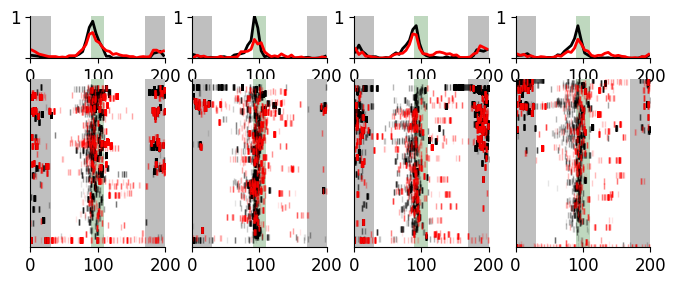

In [36]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
# get sorting analyzer and unit locations
vr_session_base_names = ["M21_D23_2024-05-25_16-54-12_VR1",
                         "M21_D24_2024-05-26_16-35-19_VR1",
                         "M21_D25_2024-05-27_16-00-30_VR1", 
                         "M21_D26_2024-05-28_17-04-41_VR1",]

fig, axs = plt.subplots(2, 4, figsize=(8, 3), sharex=True, gridspec_kw={'height_ratios': [1, 4]})  
for i, vr_name in enumerate(vr_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
    processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
    position_data = pd.read_csv(position_path)
    processed_position_data = pd.read_pickle(processed_position_path)
    plot_stop_hists(processed_position_data, track_length=200, ax=axs[0, i], ymax=1)
    plot_stop_raster(processed_position_data, track_length=200, ax=axs[1, i])
plt.show()


    
